In [1]:
import re
import os
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [2]:
IMG_DIR = '../input/'

In [32]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
# Gaussian Blurring
def remove_noise_gausian(image):
    return cv2.GaussianBlur(image,(5,5),0)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 
img = cv2.imread('image.jpg')

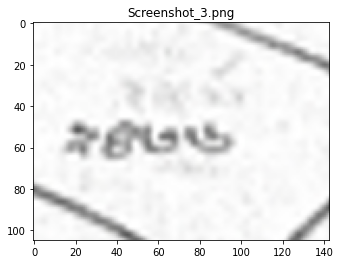

In [33]:
# Plot original image

image_name = 'Screenshot_3.png'

image = cv2.imread( os.path.join( IMG_DIR , image_name))
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title(image_name)
plt.show()

In [34]:
# Preprocess image 

from random import gauss


gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
gausian = remove_noise_gausian(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'gausian':gausian,
          'canny': canny
          }

IndexError: list index out of range

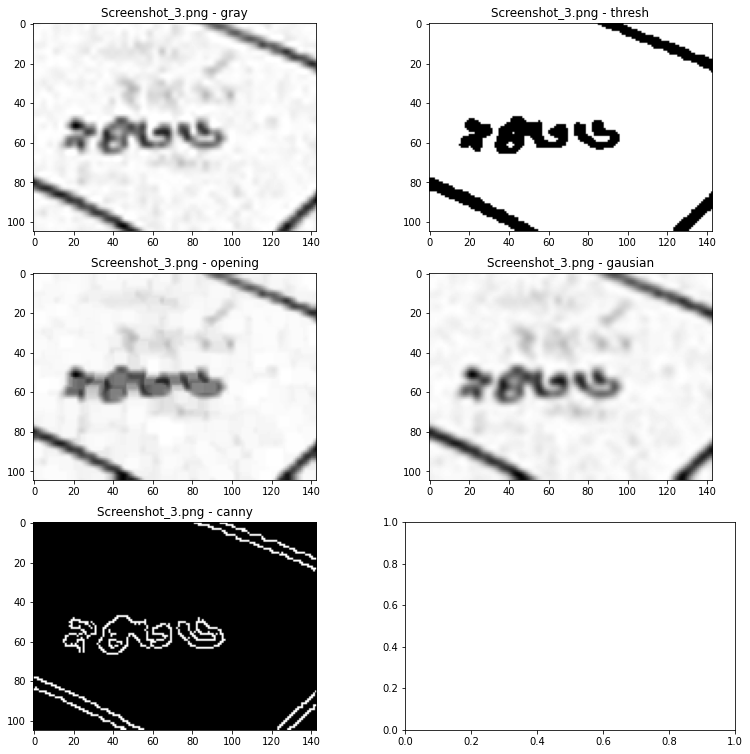

In [36]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 3
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(image_name+' - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')    

In [37]:
# Get OCR output using Pytesseract

# custom_config = r'--oem 3 --psm 6'
custom_config = r'-l ben --oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(thresh, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(opening, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(canny, config=custom_config))
print('TESSERACT OUTPUT --> Gausian Blur')
print('-----------------------------------------')
print(pytesseract.image_to_string(gausian, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
টি
চে
৬ ৮


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
সি
৯৪৭৩৬
সি টি


-----------------------------------------
TESSERACT OUTPUT --> OPENED IMAGE
-----------------------------------------
সি
শিস
হে ৮


-----------------------------------------
TESSERACT OUTPUT --> CANNY EDGE IMAGE
-----------------------------------------
০
নী$৬৪৩
৯২২২ 5

TESSERACT OUTPUT --> Gausian Blur
-----------------------------------------
টি
চে
হি ৮৮



) তা
২২৮৫৯



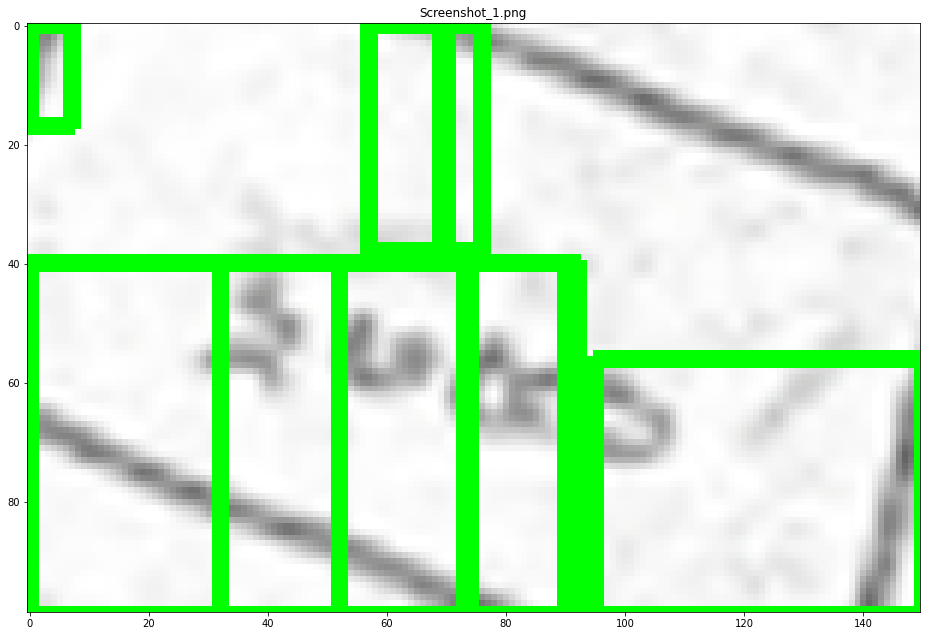

In [41]:
# Plot character boxes on image using pytesseract.image_to_boxes() function

image_name = 'Screenshot_1.png'

image = cv2.imread( os.path.join( IMG_DIR , image_name))
# image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image,config=custom_config)
print(pytesseract.image_to_string(image, config=custom_config)) 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
# plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.title(image_name)
plt.show()

) তা
২২৮৫৯

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


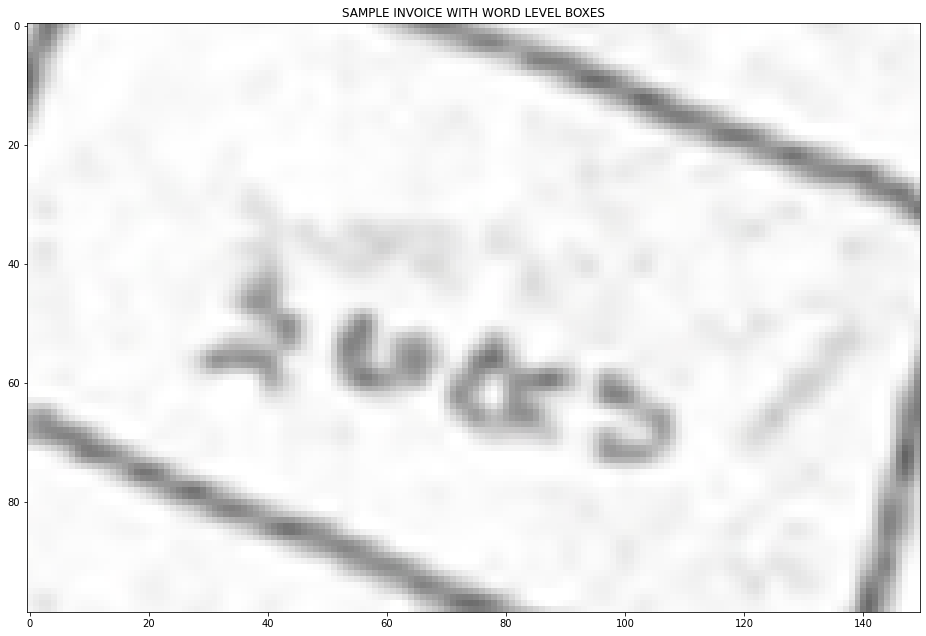

In [44]:
# Plot word boxes on image using pytesseract.image_to_data() function

image_name = 'Screenshot_1.png'

image = cv2.imread( os.path.join( IMG_DIR , image_name))
# image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')
d = pytesseract.image_to_data(image, config=custom_config, output_type=Output.DICT)
print(pytesseract.image_to_string(image, config=custom_config)) 
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH WORD LEVEL BOXES')
plt.show()

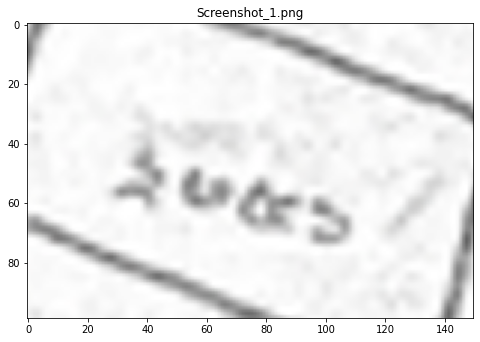

In [12]:
# working with multiple languages

# Plot original image

image_name = 'Screenshot_1.png'

image = cv2.imread( os.path.join( IMG_DIR , image_name))

# image = cv2.imread(IMG_DIR + 'greek-thai.png')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(8,16))
plt.imshow(rgb_img, cmap = 'gray')
# plt.title('MULTIPLE LANGUAGE IMAGE')
plt.title(image_name)
plt.show()

In [13]:

# # Output with only english language specified

# custom_config = r'-l eng --oem 3 --psm 6'
# print(pytesseract.image_to_string(image, config=custom_config))

# # Output with all languages specified

# custom_config = r'-l grc+tha+eng --oem 3 --psm 6'
# print(pytesseract.image_to_string(image, config=custom_config))


# Output with all languages specified

custom_config = r'-l ben --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

) তা
২২৮৫৯

